# Thrift Hunter Machine Learning Model

## Download and prepare the dataset

In [1]:
# Permission to download the dataset
! chmod 600 /content/kaggle.json

In [2]:
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d dqmonn/zalando-store-crawl

 99% 2.22G/2.24G [00:17<00:00, 140MB/s]
100% 2.24G/2.24G [00:18<00:00, 133MB/s]


In [3]:
# Extract the dataset
import zipfile

zip_file = zipfile.ZipFile('/content/zalando-store-crawl.zip')
zip_file.extractall('/content/')

In [4]:
# Check one of the images inside the dataset
import cv2

img = cv2.imread("/content/zalando/longsleeve/1VJ22O059-Q11@7.jpg")

img.shape

(875, 606, 3)

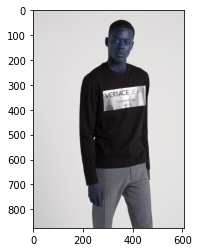

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [6]:
!rm -rf /content/zalando/zalando

In [7]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Split folders
import splitfolders
from sklearn.model_selection import train_test_split

input_folder = '/content/zalando'

# train, val
splitfolders.ratio(input_folder, output="/content/zalando2", 
                   seed=42, ratio=(.8, .2), 
                   group_prefix=None) # default values

Copying files: 16186 files [00:04, 3382.95 files/s]


## Prepare the ImageDataGenerator

In [9]:
# Initialize ImageDataGenerator for training and testing
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale= 1./255,                                                                                                                   
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range = 0.2, 
                               horizontal_flip=True,
                               fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale= 1./255)

In [10]:
# Take image data from directory and resize it
TRAINING_DIR = '/content/zalando2/train'
VALIDATION_DIR = '/content/zalando2/val'

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                           target_size = (150,150),
                                           class_mode = 'categorical',
                                           batch_size = 126)

val_generator = val_datagen.flow_from_directory(VALIDATION_DIR,
                                         target_size = (150,150),
                                         class_mode = 'categorical',
                                         batch_size = 126)

Found 12943 images belonging to 6 classes.
Found 3237 images belonging to 6 classes.


In [11]:
labels = list(train_generator.class_indices.keys())

labels

['hoodies',
 'hoodies-female',
 'longsleeve',
 'shirt',
 'sweatshirt',
 'sweatshirt-female']

## Build the model

In [12]:
# Build ResNet model
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = ResNet50V2(weights='imagenet',
                   input_shape=(150,150,3),
                   include_top=False)

input = Input(shape=(150,150,3))

x = base_model(input)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)

output = Dense(6, activation='softmax')(x)

model = Model(input, output)

94683136/94668760 [==============================] - 1s 0us/step


In [14]:
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 6)                 3078      
                                                             

In [15]:
# Compile the model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# Set the training parameters
model.compile(
    loss = categorical_crossentropy,
    optimizer = Adam(),
    metrics = ['accuracy'])

## Train the model and evaluate the results

In [16]:
# Fit the data to the model
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=102,
    validation_data=val_generator,
    verbose=1,
    validation_steps=25)

Epoch 1/10
102/102 [==============================] - 263s 2s/step - loss: 1.1461 - accuracy: 0.5398 - val_loss: 5.1269 - val_accuracy: 0.1533
Epoch 2/10
102/102 [==============================] - 235s 2s/step - loss: 0.8534 - accuracy: 0.6214 - val_loss: 3.0653 - val_accuracy: 0.2930
Epoch 3/10
102/102 [==============================] - 233s 2s/step - loss: 0.7605 - accuracy: 0.6498 - val_loss: 10.7394 - val_accuracy: 0.1860
Epoch 4/10
102/102 [==============================] - 232s 2s/step - loss: 0.7048 - accuracy: 0.6686 - val_loss: 1.5007 - val_accuracy: 0.5210
Epoch 5/10
102/102 [==============================] - 232s 2s/step - loss: 0.6816 - accuracy: 0.6768 - val_loss: 1.2426 - val_accuracy: 0.5156
Epoch 6/10
102/102 [==============================] - 234s 2s/step - loss: 0.6434 - accuracy: 0.6840 - val_loss: 0.8451 - val_accuracy: 0.6305
Epoch 7/10
102/102 [==============================] - 234s 2s/step - loss: 0.6301 - accuracy: 0.6907 - val_loss: 0.7544 - val_accuracy: 0.664

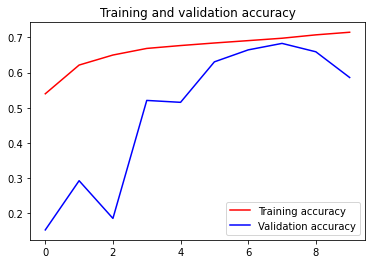

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

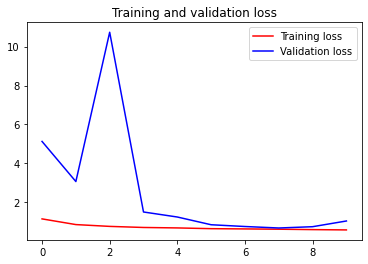

<Figure size 432x288 with 0 Axes>

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()